In [8]:
from abc import ABC, abstractmethod
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt

class NetworkGenerator(ABC):
    """
    Abstract base class for network generation.
    Defines the interface for creating different types of networks.
    """
    @abstractmethod
    def generate(self) -> nx.Graph:
        """
        Abstract method to generate a network.
        Returns:
            nx.Graph: Generated network
        """
        pass

class WattsStrogatzNetwork(NetworkGenerator):
    def __init__(self, n_nodes, k_neighbors, p_rewiring=1e-1):
        self.n = n_nodes # number of nodes
        self.k = k_neighbors # number of nearest neighbors
        self.p = p_rewiring # probability of rewiring
        self.graph = nx.Graph()

    def generate(self) -> nx.Graph:
        """create a small-world network"""
        # initialize
        self.graph = nx.Graph()
        self.graph.add_nodes_from(range(self.n))

        # create simple connection
        for i in range(self.n):
            self.graph.add_edge(i, (i+1)%self.n)
        
        # rewire k-nearest neighbors
        half_k = self.k // 2
        for i in range(self.n):
            for j in range(1, half_k+1):
                self.graph.add_edge(i, (i+j) % self.n)  
                self.graph.add_edge(i, (i-j) % self.n)
        
        # rewire edges
        # 隣接行列の表を意識して！
        edges = list(self.graph.edges())
        for u, v in edges:
            if random.random() < self.p:
                # remove a edge
                self.graph.remove_edge(u, v)
                # select new endpoint
                while True:
                    new_node = random.randint(0, self.n - 1)
                    if new_node != u and not self.graph.has_edge(u, new_node):
                        break
                self.graph.add_edge(u, new_node)
        
        return self.graph
    
    def draw(self, G: nx.Graph):
        # draw a SmallWorldNetwork 
        pos = nx.circular_layout(G)
        nx.draw(G, pos, node_size=30, node_color='red')
        plt.axis('off')
        plt.show()


In [9]:
class NetworkAnalyzer:
    """class to analyze networks"""
    def calculate_metrics(self, G: nx.Graph):
        """compute network's metrics"""
        
        # calculate the path fo each of the subgraph
        path_temp = []
        weights = []
        for subgraph in (G.subgraph(c).copy() for c in nx.connected_components(G)):
            path_temp.append(nx.average_shortest_path_length(subgraph))
        # create a variable weight that holds the size of each subgraph (or connected component)
        # alternatively I have weighted by graph size but we could use anything to weight the average
        for components in nx.connected_components(G):
            weights.append(len(components))
        # compute the weighted average
        avg_shotest_path = np.average(path_temp,weights = weights) 
        avg_cluster = nx.average_clustering(G)
        
        return avg_shotest_path, avg_cluster
    
    def analyze_propaties(self, generator: NetworkGenerator, num_points=10) -> tuple:
        """anylize properties of the network as p changes"""
        p_values = np.logspace(-4, 0, num=num_points)
        L_values = []
        C_values = []
        for p in p_values:
            if hasattr(generator, 'p'):
                generator.p = p
            G = generator.generate()
            L, C = self.calculate_metrics(G)
            L_values.append(L)
            C_values.append(C)

        return p_values, np.array(L_values), np.array(C_values)

    def plot_propaties(self, p_values, L_values, C_values):
        """plot propaties of the network"""
        plt.figure(figsize=(12, 4))
        plt.plot(p_values, L_values/L_values[0], label="average shortest path length")
        plt.plot(p_values, C_values/C_values[0], label="average clustering coefficient")
        plt.xscale("log")
        plt.xlabel("rewiring probability")
        plt.ylabel("normalized values of metrics")
        plt.grid(True)
        plt.legend()
        plt.show()


In [10]:
class NetworkSimulator:
    """SIRモデルのシミュレーションを行うクラス"""
    def __init__(self, beta: float, gamma: float):
        """
        初期化
        Args:
            beta (float): 感染率
            gamma (float): 回復率
        """
        self.beta = beta  # 感染率
        self.gamma = gamma  # 回復率
        
    def run_sir(self, G: nx.Graph, initial_infected: list, num_steps: int) -> dict:
        """
        SIRモデルのシミュレーションを実行
        Args:
            G (nx.Graph): シミュレーション対象のネットワーク
            initial_infected (list): 初期感染ノードのリスト 
            num_steps (int): シミュレーションのステップ数
        Returns:
            dict: 各時点でのS,I,Rの数を含む辞書
        """
        # ノードの状態を初期化 (S=0, I=1, R=2)
        states = {node: 0 for node in G.nodes()}
        for node in initial_infected:
            states[node] = 1
            
        # 結果を記録
        results = {'S': [], 'I': [], 'R': []}
        
        # シミュレーション実行
        for step in range(num_steps):
            # 現在の状態を記録
            s = sum(1 for state in states.values() if state == 0)
            i = sum(1 for state in states.values() if state == 1)
            r = sum(1 for state in states.values() if state == 2)
            results['S'].append(s)
            results['I'].append(i) 
            results['R'].append(r)
            
            # 状態更新
            new_states = states.copy()
            for node in G.nodes():
                if states[node] == 0:  # Susceptible
                    # 隣接ノードからの感染をチェック
                    for neighbor in G.neighbors(node):
                        if states[neighbor] == 1 and random.random() < self.beta:
                            new_states[node] = 1
                            break
                elif states[node] == 1:  # Infected
                    # 回復をチェック
                    if random.random() < self.gamma:
                        new_states[node] = 2
            states = new_states
            
        return results

    def plot_results(self, results: dict, type: str):
        """
        SIRモデルのシミュレーション結果をプロット
        
        Args:
            results (dict): run_sirメソッドから返された結果辞書
        """
        plt.figure(figsize=(10, 6))
        # 各状態の時系列プロット
        time = range(len(results['S']))
        plt.plot(time, results['S'], 'b-', label='Susceptible')
        plt.plot(time, results['I'], 'r-', label='Infected') 
        plt.plot(time, results['R'], 'g-', label='Recovered')
        
        # グラフの設定
        plt.xlabel('Time step')
        plt.ylabel('Number of nodes')
        plt.title(f'SIR Model Simulation on {type}')
        plt.grid(True)
        plt.legend()
        plt.show()


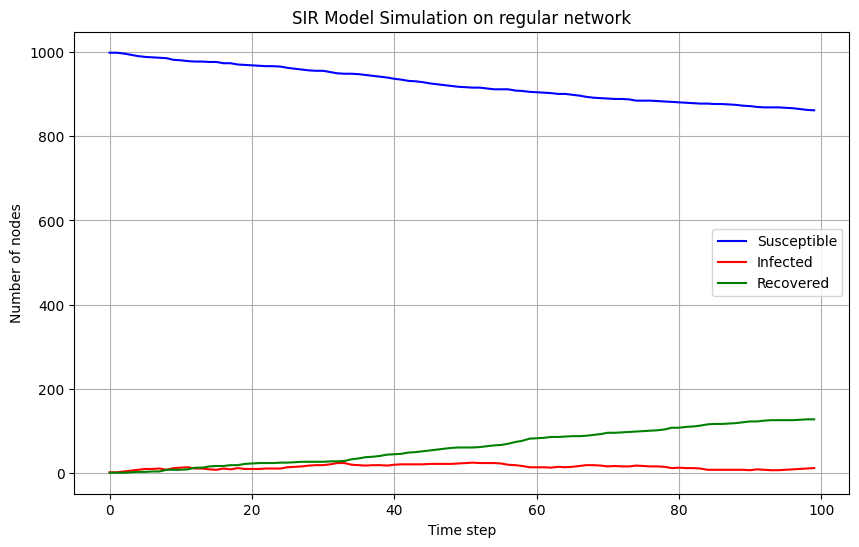

In [11]:
# regular network

# ネットワークの生成
network = WattsStrogatzNetwork(n_nodes=1000, k_neighbors=4, p_rewiring=0) # p=0: レギュラーネットワーク
G = network.generate()

# シミュレーターの初期化
simulator = NetworkSimulator(beta=0.3, gamma=0.1)

# シミュレーション実行
initial_infected = [random.randint(0, 500)]  # ランダムに一つ感染
results = simulator.run_sir(G, initial_infected, num_steps=100)

# 結果のプロット
simulator.plot_results(results, "regular network")


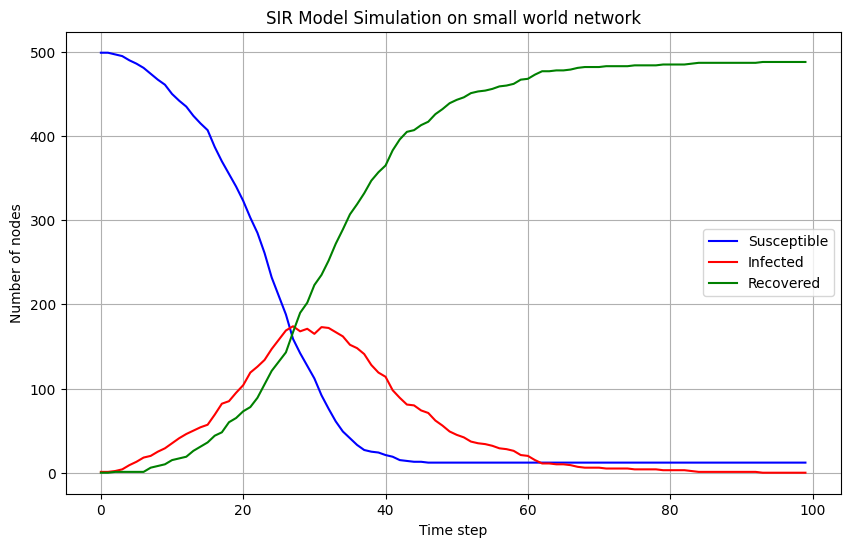

In [ ]:
# small world network

# ネットワークの生成
network = WattsStrogatzNetwork(n_nodes=500, k_neighbors=4, p_rewiring=0.1) # p=0.1(0<p<1): スモールワールドネットワーク

G = network.generate()

# シミュレーターの初期化
simulator = NetworkSimulator(beta=0.3, gamma=0.1)

# シミュレーション実行
initial_infected = [random.randint(0, 500)]  # ランダムに一つ感染
results = simulator.run_sir(G, initial_infected, num_steps=100)

# 結果のプロット
simulator.plot_results(results, type="small world network")


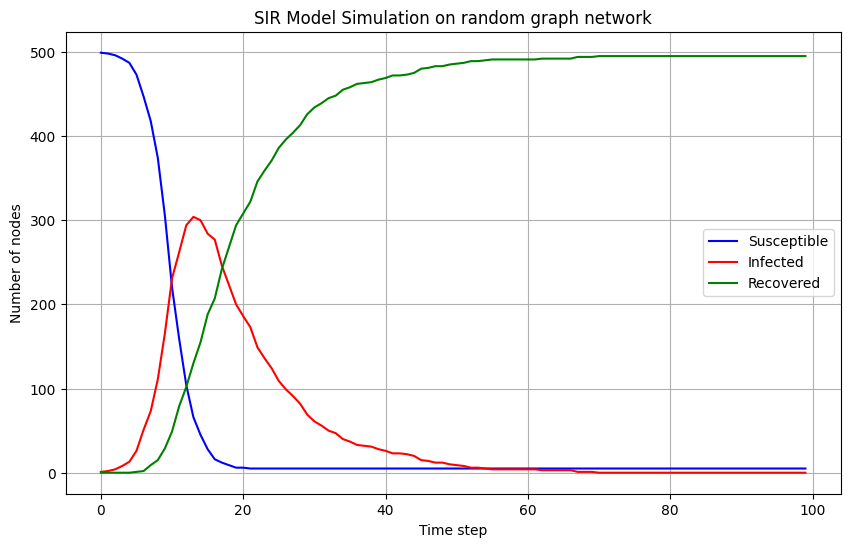

In [13]:
# random graph network

# ネットワークの生成
network = WattsStrogatzNetwork(n_nodes=500, k_neighbors=4, p_rewiring=1) # p=1: ランダムグラフネットワーク

G = network.generate()

# シミュレーターの初期化
simulator = NetworkSimulator(beta=0.3, gamma=0.1)

# シミュレーション実行
initial_infected = [random.randint(0, 500)]  # ランダムに一つ感染
results = simulator.run_sir(G, initial_infected, num_steps=100)

# 結果のプロット
simulator.plot_results(results, "random graph network")
